<a href="https://colab.research.google.com/github/Mobad225/Clustering-Evaluation/blob/master/Clustering_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inserting Data

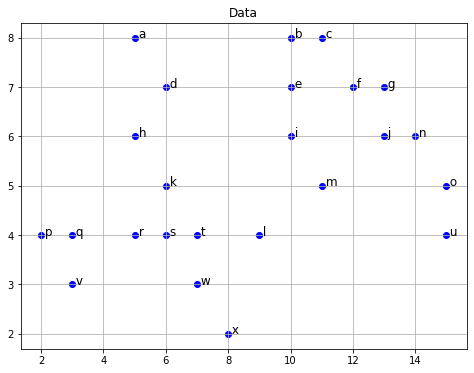

In [92]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([(5, 10, 11, 6, 10, 12, 13, 5, 10, 13, 6, 9, 11, 14, 15, 2, 3,
                  5, 6, 7, 15, 3, 7, 8), (8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 5, 4,
                                           5, 6, 5, 4, 4, 4, 4, 4, 4, 3, 3, 2)])
data = data.T
plt.figure(figsize = (8, 6))
plt.scatter(data[:,0], data[:,1], color = 'blue')
it = 0
for i_x, i_y in zip(data[:,0], data[:,1]):
  plt.text(i_x, i_y, ' {}'.format(chr(ord('a') + it)), fontsize = 12)
  it+=1
plt.grid(True)
plt.title('Data')
plt.show()
plt.close()

# Q1) K-means Clustering for k = 2, 3, 4, 5, 6

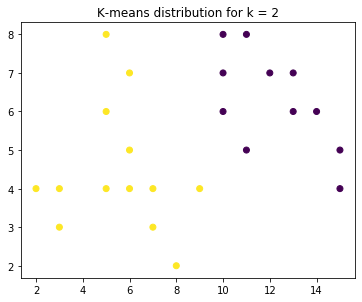

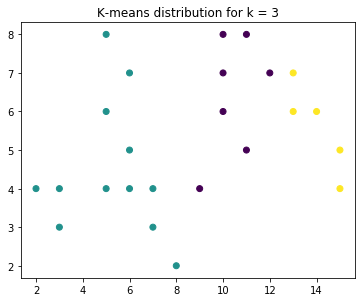

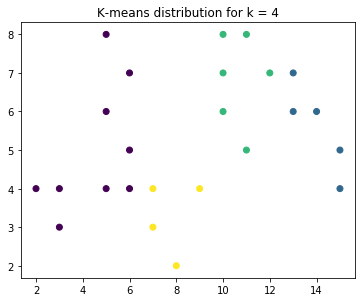

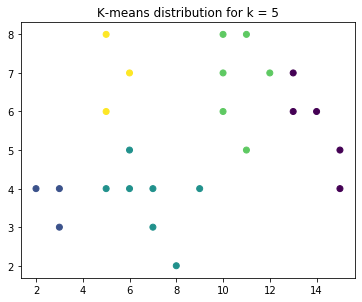

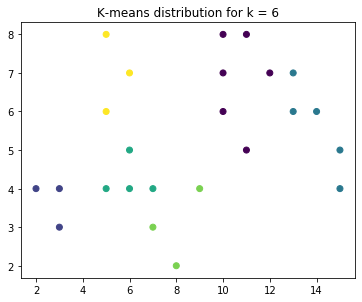

In [93]:
from sklearn.cluster import KMeans

for i in range(2, 7):
  kmeans = KMeans(n_clusters = i, random_state=0).fit(data)
  pred = kmeans.labels_
  plt.figure(figsize = (6, 4.7))
  plt.scatter(data[:,0], data[:,1], c = pred)
  plt.title('K-means distribution for k = {}'.format(i))
  plt.show()
  plt.close()

# Q2) K-way Normalized cut for k = 2, 3, 4, 5, 6

### Function to get Spectral Clustering using KNN Adjacency List

In [0]:
from sklearn.cluster import SpectralClustering
import warnings

warnings.filterwarnings("ignore")

def spectral_cluster(k = 2, KNN = 3):
  clustering = SpectralClustering(n_clusters = k, n_neighbors = KNN, 
                                  assign_labels = "discretize", random_state = 0, 
                                  affinity = 'nearest_neighbors').fit(data)
  return clustering.labels_

def draw_with_labels(labels, title = None):
  plt.scatter(data[:,0], data[:,1], c = labels)
  plt.title(title)
  plt.show()
  plt.close()

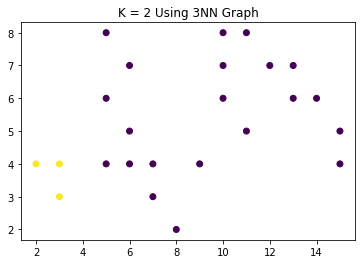

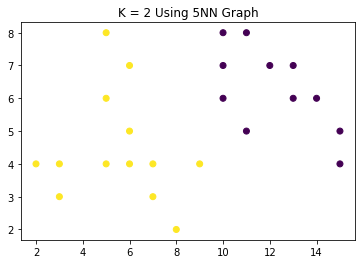

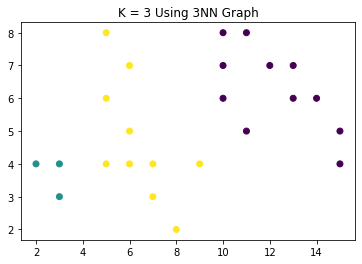

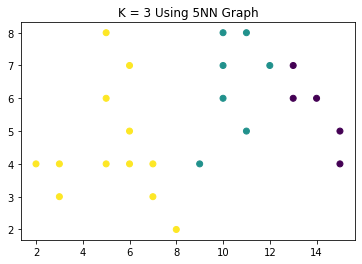

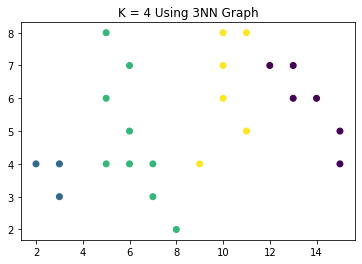

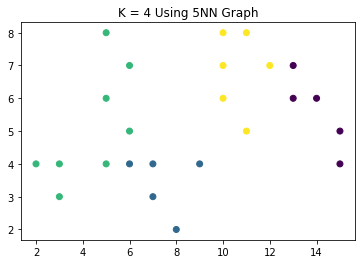

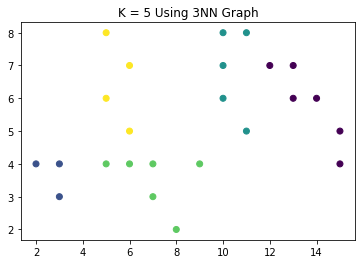

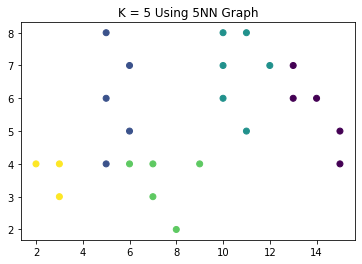

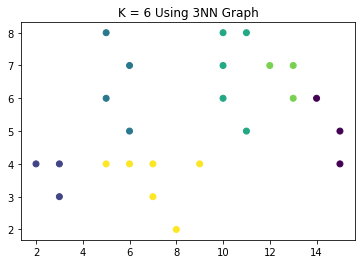

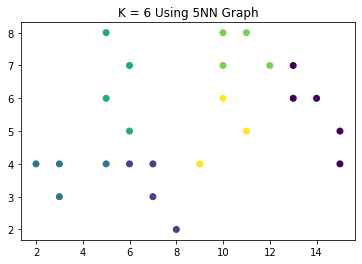

In [95]:
from sklearn.neighbors import kneighbors_graph

for i in range(2, 7):
  draw_with_labels(spectral_cluster(k = i, KNN = 3),
                   title = 'K = {} Using 3NN Graph'.format(i))
  draw_with_labels(spectral_cluster(k = i, KNN = 5),
                   title = 'K = {} Using 5NN Graph'.format(i))
  print()

# Q3) Evaluating Clustering for k = 3

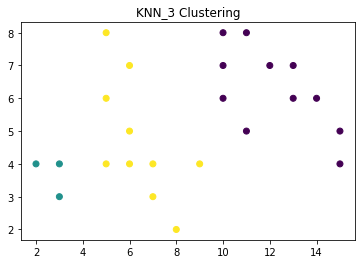

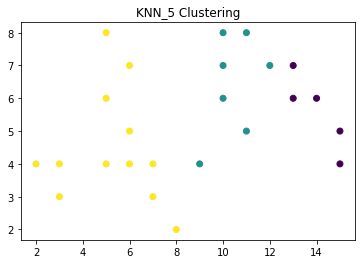

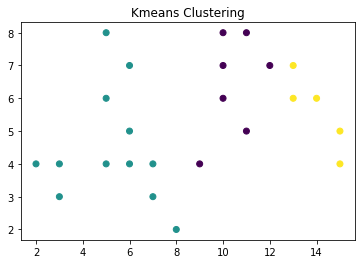

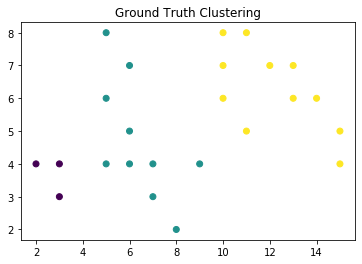

In [96]:
kmeans = KMeans(n_clusters = 3, random_state=0).fit(data)
kmeans_cluster = kmeans.labels_ 
truth = np.array([2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 2, 2,
                  3, 1, 2, 2])

#Plotting
draw_with_labels(spectral_cluster(k = 3, KNN = 3), title = 'KNN_3 Clustering')
draw_with_labels(spectral_cluster(k = 3, KNN = 5), title = 'KNN_5 Clustering')
draw_with_labels(kmeans_cluster, title = 'Kmeans Clustering')
draw_with_labels(truth, title = 'Ground Truth Clustering')

# Question 3)

# Kmeans Clustering:
## Purity = $(\frac{12}{24}) * (\frac{3}{12}) + (\frac{7}{24})*(\frac{1}{7}) + (\frac{5}{24}) * (\frac{5}{5}) = 0.375$
## Max Matching = 0 + 9 + 5 = 14 Correct Matches = 58.33%.
## Jaccard index = $\frac{16}{16 + 39 + 33} = 0.18$
## Rand index = $\frac{16 + 137}{16 + 137 + 39 + 33} = 0.68$
## F Measure = $\frac{1}{3} *( \frac{2 * \frac{3}{12}* \frac{3}{3}}{\frac{3}{12}+ \frac{3}{3}} + \frac{2 * \frac{1}{7}*\frac{1}{10}}{ \frac{1}{7}+\frac{1}{10}} + \frac{2 * \frac{5}{5}*\frac{5}{11}}{\frac{5}{5} + \frac{5}{11}}) = 0.381$

# 5-KNN Spectral Clustering
## Purity = 1
## Max Matching = 24 Correct Matches = 100%
## Jaccard index = $\frac{103}{103 + 0 + 0} = 1$
## Rand index = $\frac{103 + 173}{103 + 173 + 0 + 0} = 1$
## F Measure = $\frac{1}{3}(\frac{2*1*1}{2} + \frac{2*1*1}{2} + \frac{2*1*1}{2}) = 1$

# Part 2)

### BetaCV function

In [0]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import euclidean_distances
from math import ceil
import numpy as np
import time

def betacv(data, labels, metric='euclidean'):
    distances = pairwise_distances(data, metric=metric)
    n = labels.shape[0]
    A = np.array([intra_cluster_distance(distances[i], labels, i)
                  for i in range(n)])
    B = np.array([inter_cluster_distance(distances[i], labels, i)
                  for i in range(n)])
    a = np.sum(A)
    b = np.sum(B)
    labels_unq = np.unique(labels)
    members = np.array([member_count(labels, i) for i in labels_unq])
    N_in = np.array([i*(i-1) for i in members])
    n_in = np.sum(N_in)
    N_out = np.array([i*(n-i) for i in members])
    n_out = np.sum(N_out)
    betacv = (a/n_in)/(b/n_out)
    return betacv

def intra_cluster_distance(distances_row, labels, i):
    mask = labels == labels[i]
    mask[i] = False
    if not np.any(mask):
        # cluster of size 1
        return 0
    a = np.sum(distances_row[mask])
    return a

def inter_cluster_distance(distances_row, labels, i):
    mask = labels != labels[i]
    b = np.sum(distances_row[mask])
    return b

def member_count(labels, i):
    mask = labels == i
    return len(labels[mask])

In [98]:
print('BetaCV for Kmeans clustering : %.3f' % betacv(data, kmeans_cluster), sep = '')
print('BetaCV for 3-NN Spectral clustering : %.3f' % betacv(data, KNN_3), sep = '')
print('BetaCV for 5-NN Spectral clustering : %.3f' % betacv(data, KNN_5), sep = '')

BetaCV for Kmeans clustering : 0.438
BetaCV for 3-NN Spectral clustering : 0.441
BetaCV for 5-NN Spectral clustering : 0.452
